In [4]:
## Idea 1

# I think it would be helpful to predict the demand quantity for each part item (`niin_nomenclature`) for future dates, either aggregated by month or by day of the week. This will help with proactive inventory planning.

# I wonder whether specific months or days of the week consistently require more or less parts than others.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt



In [6]:
import os

downloads_path = os.path.expanduser("~/Downloads")
os.chdir(downloads_path)

print("Current Directory:", os.getcwd())


Current Directory: /Users/jasonchen/Downloads


In [7]:
hvacdata = pd.read_csv('hvac_merged.csv')


/var/folders/9f/3yz89nb525nczbywh5dl11kh0000gn/T/ipykernel_66672/1081890662.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  hvacdata = pd.read_csv('hvac_merged.csv')


In [8]:
hvacdata.head()



,uic,job_seq,apl,cause_code,cdm_rin,csmp_narrative_summary,date_closing,date_maintenance_action,deferral_reason_code,due_date,...,total_price,action_taken_code,loc1,loc2,loc3,loc4,cwtDays,totPrice,totMaterialCost,daysOpen
0,R03369,36493414,43A030026,7,86KYW,PARTS MISSING,2018-05-08,2018-07-16,2.0,NaN,...,50.92,1,2,200,01,Q,8.0,50.92,50.92,0.0
1,R03369,36493441,611330020,7,0KYWX,PARTS MISSING,2018-05-10,2018-07-16,2.0,NaN,...,10.35,1,2,180,0,L,8.0,10.35,10.35,0.0
2,R23170,36496418,611330020,7,0UXWY,PARTS MISSING,2018-05-29,2018-07-16,2.0,NaN,...,10.35,1,2,84,0,Q,8.0,10.35,10.35,0.0
3,R21853,36305764,18550014,7,02THE,PARTS BROKEN,2018-04-12,2018-05-11,2.0,NaN,...,20.00,1,03,148,2,Q,8.0,20.00,249.98,0.0
4,R21853,36305764,18550014,7,02THE,PARTS BROKEN,2018-04-12,2018-05-11,2.0,NaN,...,16.00,1,03,148,2,Q,8.0,16.00,249.98,0.0


In [14]:
hvacdata['demand_date'] = pd.to_datetime(hvacdata['demand_date'], errors='coerce')


In [16]:
demand_df = hvacdata.dropna(subset=['demand_date', 'niin_nomenclature', 'quantity'])

# Exclude rows where niin_nomenclature is "Unknown"
demand_df = demand_df[demand_df['niin_nomenclature'].str.lower() != 'unknown']

print("Filtered shape:", demand_df.shape)
print("Top 5 unique parts after filtering:")
print(demand_df['niin_nomenclature'].value_counts().head())


Filtered shape: (34582, 73)
Top 5 unique parts after filtering:
niin_nomenclature
FILTER ELEMENT,AIR     12225
O-RING                  1445
BELT,V                  1015
BEARING,BALL,ANNULA      972
GASKET                   759
Name: count, dtype: int64


In [17]:
print("Shape of demand dataset:", demand_df.shape)
print("\nTop 5 rows:\n", demand_df[['demand_date', 'niin_nomenclature', 'quantity']].head())

Shape of demand dataset: (34582, 73)

Top 5 rows:
    demand_date   niin_nomenclature  quantity
16  2022-05-30  FILTER ELEMENT,AIR       1.0
17  2022-05-30  FILTER ELEMENT,AIR       1.0
18  2022-05-30  FILTER ELEMENT,AIR       1.0
19  2022-05-30  FILTER ELEMENT,AIR       1.0
20  2022-05-24  FILTER ELEMENT,AIR       1.0


In [18]:
# most frequently requested parts
top_parts = demand_df['niin_nomenclature'].value_counts().head(10)
print("\nTop 10 most requested parts:\n", top_parts)


Top 10 most requested parts:
 niin_nomenclature
FILTER ELEMENT,AIR     12225
O-RING                  1445
BELT,V                  1015
BEARING,BALL,ANNULA      972
GASKET                   759
SWITCH,THERMOSTATIC      737
FILTER,AIR,DISPOSAB      697
LOUDSPEAKER,PERMANE      636
LAMP,INCANDESCENT        500
RELAY,ELECTROMAGNET      399
Name: count, dtype: int64


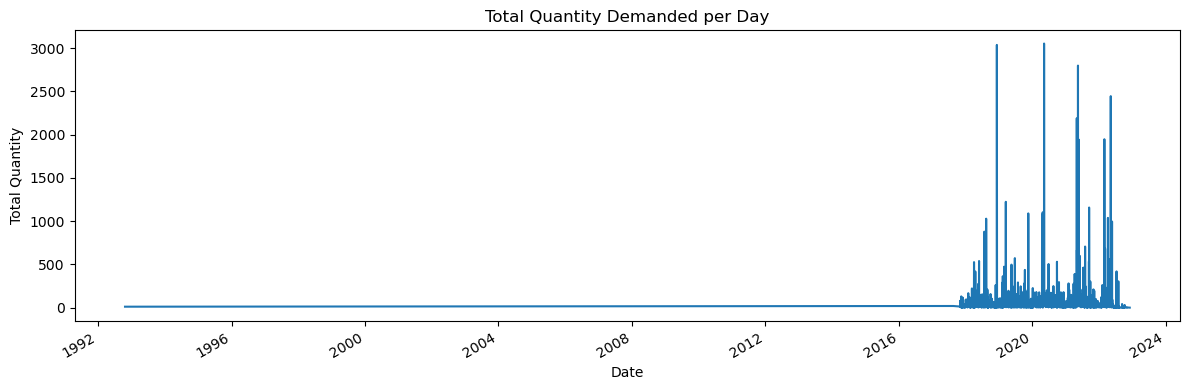

In [19]:
# quantity demanded over time
daily_demand = demand_df.groupby('demand_date')['quantity'].sum()

plt.figure(figsize=(12, 4))
daily_demand.plot()
plt.title("Total Quantity Demanded per Day")
plt.xlabel("Date")
plt.ylabel("Total Quantity")
plt.tight_layout()
plt.show()


In [20]:

print(demand_df.columns.tolist())



# new date features
demand_df['demand_year'] = demand_df['demand_date'].dt.year
demand_df['demand_month'] = demand_df['demand_date'].dt.month
demand_df['demand_dayofweek'] = demand_df['demand_date'].dt.day_name()

print(demand_df[['demand_date', 'demand_year', 'demand_month', 'demand_dayofweek']].head())


['uic', 'job_seq', 'apl', 'cause_code', 'cdm_rin', 'csmp_narrative_summary', 'date_closing', 'date_maintenance_action', 'deferral_reason_code', 'due_date', 'eic', 'equipment_nomenclature', 'eswbs_opening', 'iuc_screening_code', 'location', 'mhc', 'mho', 'mhr', 'priority_code', 'safety_code', 'status_code', 'tycom_screening_code', 'type_availability_code', 'type_of_maintenance_action', 'when_discovered_code', 'work_center', 'total_ima_man_hours', 'total_ship_force_man_hours', 'total_replacement_cost', 'total_repair_replacement_cost', 'def_narrative', 'nondef_narrative', 'closing_narrative', 'ima_narrative', 'total_material_cost', 'opening_ship_system', 'job_status', 'days_open', 'action_taken', 'intermediate_unit_commander_screening', 'priority', 'type_of_availability_needed', 'tycom_screening', 'when_discovered', 'cause', 'deferral_reason', 'feasible_with_ship_inventory', 'feasible_with_additional_dla_inventory', 'ship', 'uic_s', 'jsn', 'date_closing_s', 'demand_date', 'issue_date', 'c

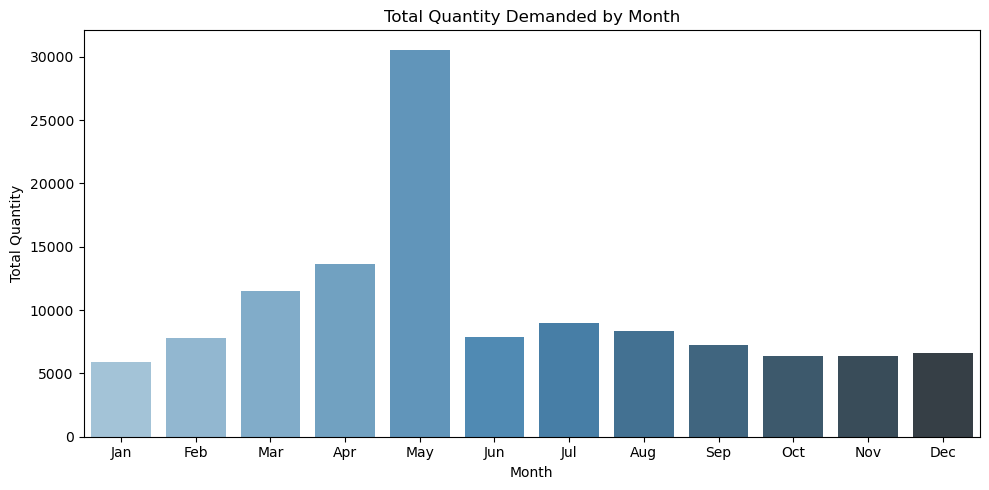

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# total quantity by month
monthly_demand = demand_df.groupby('demand_month')['quantity'].sum().reindex(range(1,13))

plt.figure(figsize=(10,5))
sns.barplot(x=monthly_demand.index, y=monthly_demand.values, palette='Blues_d')
plt.title("Total Quantity Demanded by Month")
plt.xlabel("Month")
plt.ylabel("Total Quantity")
plt.xticks(ticks=range(0,12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
plt.tight_layout()
plt.show()


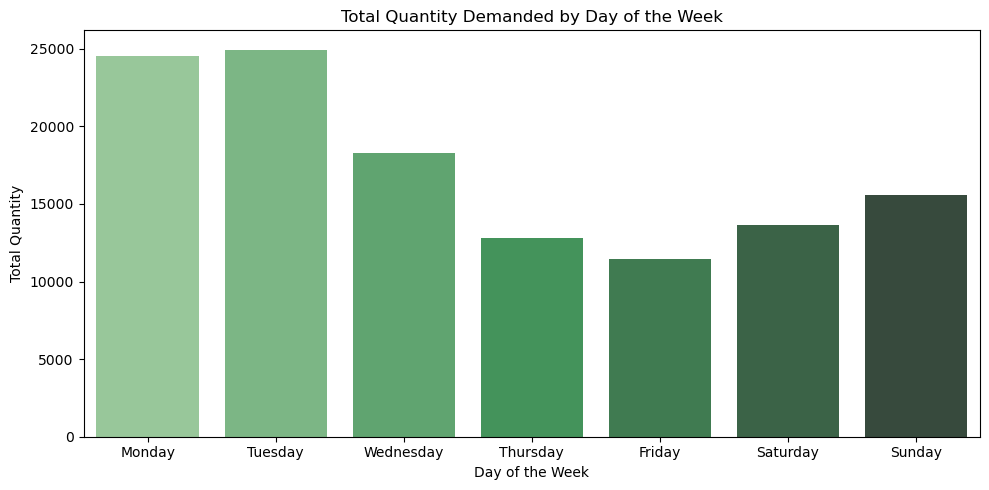

In [22]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_demand = demand_df.groupby('demand_dayofweek')['quantity'].sum().reindex(day_order)

plt.figure(figsize=(10,5))
sns.barplot(x=dow_demand.index, y=dow_demand.values, palette='Greens_d')
plt.title("Total Quantity Demanded by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Total Quantity")
plt.tight_layout()
plt.show()


In [24]:
# most requested parts by total quantity
top_parts = demand_df.groupby('niin_nomenclature')['quantity'].sum().sort_values(ascending=False)
print("Top 5 parts by total quantity:\n", top_parts.head())


Top 5 parts by total quantity:
 niin_nomenclature
FILTER ELEMENT,AIR     33086.0
SCREW,CAP,HEXAGON H     9828.0
WASHER,FLAT             7890.0
CABLE,SPECIAL PURPO     6069.0
NUT,SELF-LOCKING,HE     4871.0
Name: quantity, dtype: float64


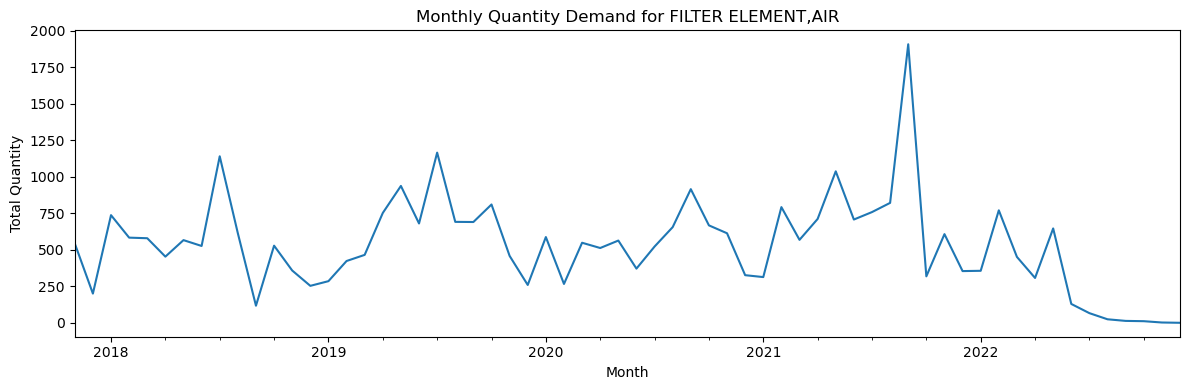

In [26]:
part_name = "FILTER ELEMENT,AIR"

# subset to filter
part_df = demand_df[demand_df['niin_nomenclature'] == part_name]

# Set date index and aggregate monthly
monthly_demand = (
    part_df.set_index('demand_date')
           .resample('M')['quantity']
           .sum()
           .fillna(0)
)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
monthly_demand.plot()
plt.title(f"Monthly Quantity Demand for {part_name}")
plt.xlabel("Month")
plt.ylabel("Total Quantity")
plt.tight_layout()
plt.show()


# seems like around quarter 3 of every year, the need for filters tend to rise


In [29]:
## Idea 2: Predictive Supply Chain Planning
# Goal: Determine which parts should be stocked  vs. ordered on-demand
# clustering (e.g. KMeans) to group parts into "should be stocked" vs "order-on-demand"

# filter clean part records
part_df = demand_df.copy()
part_df = part_df[
    (part_df['niin_nomenclature'].str.lower() != 'unknown') &
    (part_df['cwt_hours'].notna()) &
    (part_df['quantity'].notna())
]

# group by part
part_summary = part_df.groupby('niin_nomenclature').agg(
    mean_cwt=('cwt_hours', 'mean'),
    std_cwt=('cwt_hours', 'std'),
    total_quantity=('quantity', 'sum'),
    usage_frequency=('demand_date', 'nunique')
).fillna(0)

import pandas as pd
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
part_summary = part_summary.sort_values('total_quantity', ascending=False)
part_summary.head()


,mean_cwt,std_cwt,total_quantity,usage_frequency
niin_nomenclature,,,,
"FILTER ELEMENT,AIR",327.42,432.58,"33,086.00",1321
"SCREW,CAP,HEXAGON H",-315.65,745.54,"9,828.00",86
"WASHER,FLAT",-440.01,674.50,"7,890.00",80
"CABLE,SPECIAL PURPO",426.70,356.29,"6,069.00",12
"NUT,SELF-LOCKING,HE",-672.03,460.91,"4,871.00",37


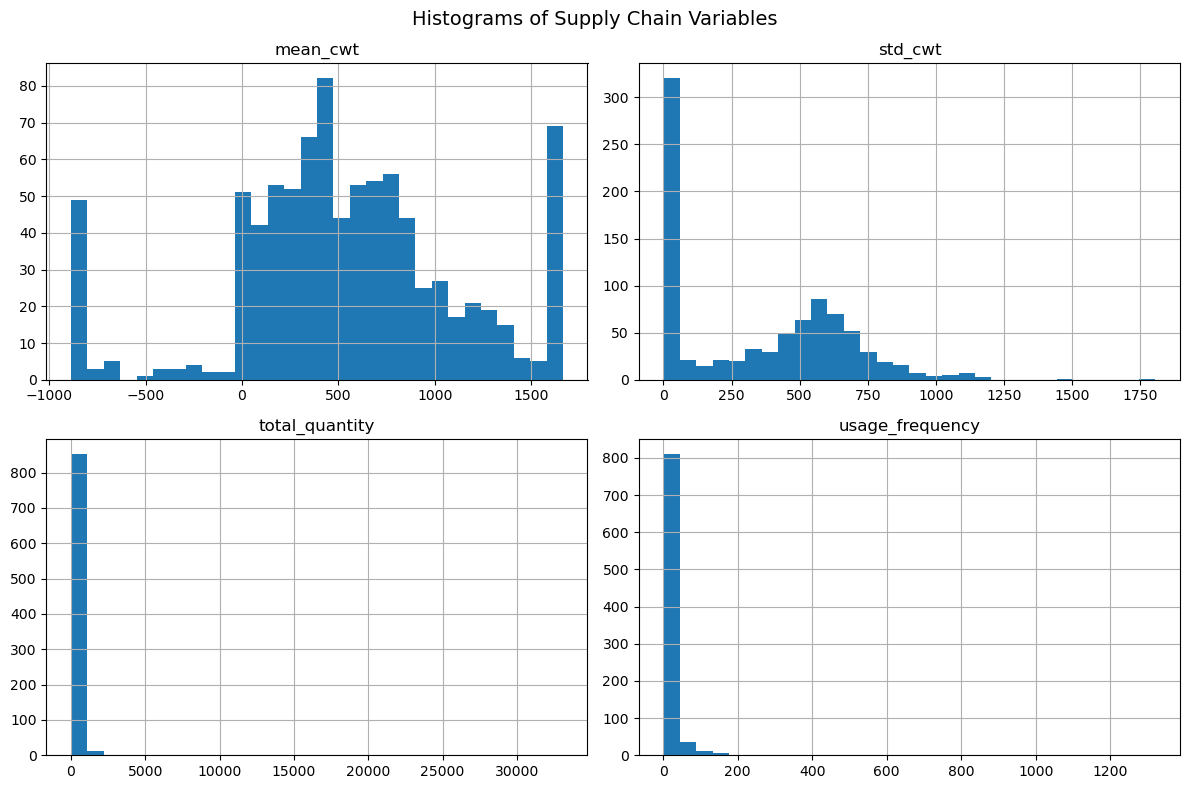

/Users/jasonchen/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


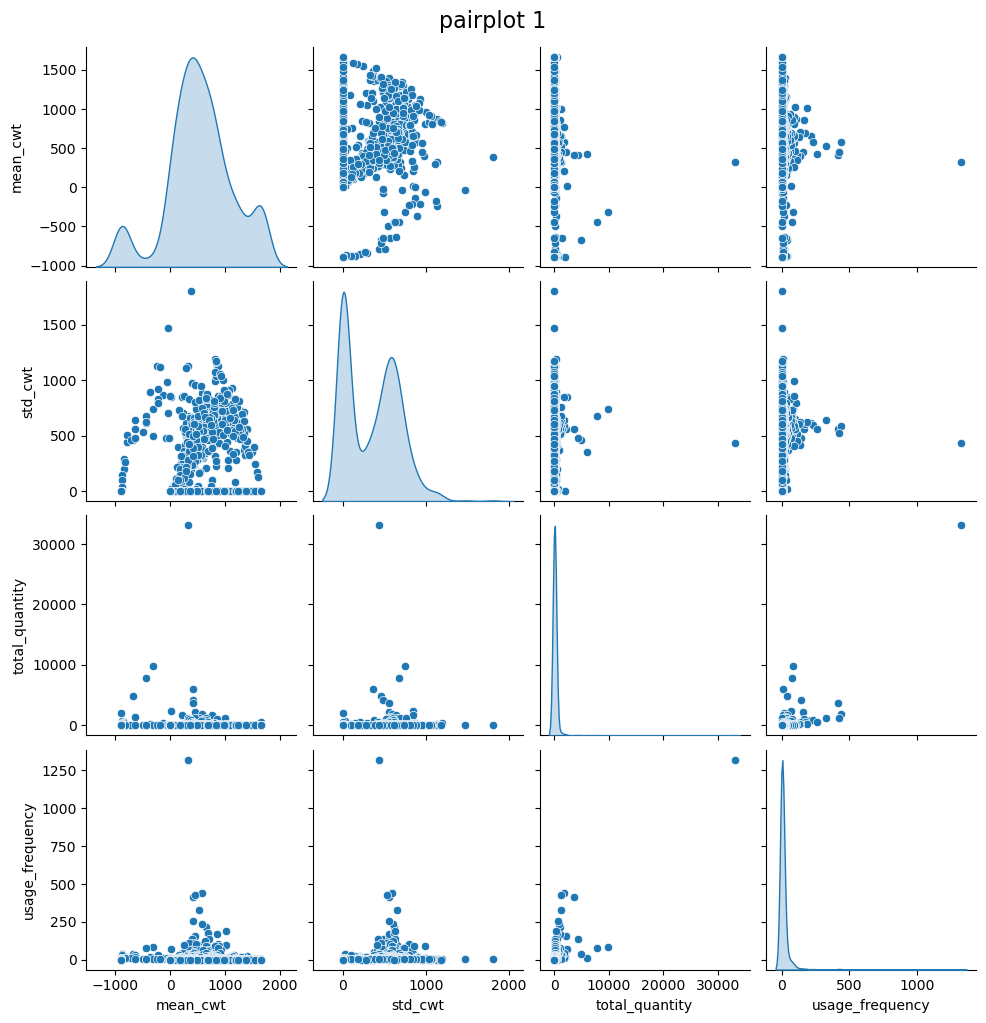

In [36]:
import matplotlib.pyplot as plt


features = ['mean_cwt', 'std_cwt', 'total_quantity', 'usage_frequency']
part_summary[features].hist(bins=30, figsize=(12, 8))
plt.suptitle("Histograms of Supply Chain Variables", fontsize=14)
plt.tight_layout()
plt.show()


# pairplot to examine relationships
sns.pairplot(part_summary[features], diag_kind="kde")
plt.suptitle("pairplot 1", y=1.02, fontsize=16)
plt.show()



# mean_cwt: many parts having moderate lead times (~200–800 hours), smaller number of parts take very long to arrive
# std_cwt: most parts have consistent delivery times (low std), other have highly unpredictable wait times